In [72]:
import torch
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo de ejecución: {device}")

Dispositivo de ejecución: cuda


In [82]:
def mostrar_imagen(image_path, transform=None):
    """Muestra imagen original y transformada"""
    img = Image.open(image_path).convert('RGB')
    
    if transform:
        img_transformed = transform(img)
        img_transformed = img_transformed.permute(1, 2, 0).numpy()
        img_transformed = (img_transformed * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_transformed = np.clip(img_transformed, 0, 1)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    
    if transform:
        plt.subplot(1, 2, 2)
        plt.imshow(img_transformed)
        plt.title('Transformada para el modelo')
        plt.axis('off')
    
    plt.show()

In [151]:
def aplicando_filtro(imagen_path, num_imagenes=4): #núm de imágenes: 4
    plt.figure(figsize=(15, 8))
    for i, filename in enumerate(os.listdir(imagen_path)[:num_imagenes]):
        if not filename.endswith('.jpeg'):  #filtra solo imágenes JPEG
            continue
        img = cv2.imread(os.path.join(imagen_path, filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        #filtros
        gaussian = cv2.GaussianBlur(img, (5, 5), 0)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_abs = np.uint8(np.absolute(sobel_x))
        
        # Muestra las mismas 4 imágenes por fila
        plt.subplot(num_imagenes, 4, i*4 + 1)
        plt.imshow(img)
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(num_imagenes, 4, i*4 + 2)
        plt.imshow(gaussian)
        plt.title('Gaussiano')
        plt.axis('off')
        
        plt.subplot(num_imagenes, 4, i*4 + 3)
        plt.imshow(sobel_abs, cmap='gray')
        plt.title('Sobel (Bordes)')
        plt.axis('off')
        
        plt.subplot(num_imagenes, 4, i*4 + 4)
        plt.imshow(gray, cmap='gray')
        plt.title('Escala de Grises')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [173]:
#Rutas de las imágenes
lung_aca_path = 'D:/CienciaDeDatos-Clases/lung_colon_image_set/lung_image_sets/lung_aca'
lung_n_path = 'D:/CienciaDeDatos-Clases/lung_colon_image_set/lung_image_sets/lung_n'
lung_scc_path = 'D:/CienciaDeDatos-Clases/lung_colon_image_set/lung_image_sets/lung_scc'

=== Adenocarcinoma (lung_aca) ===


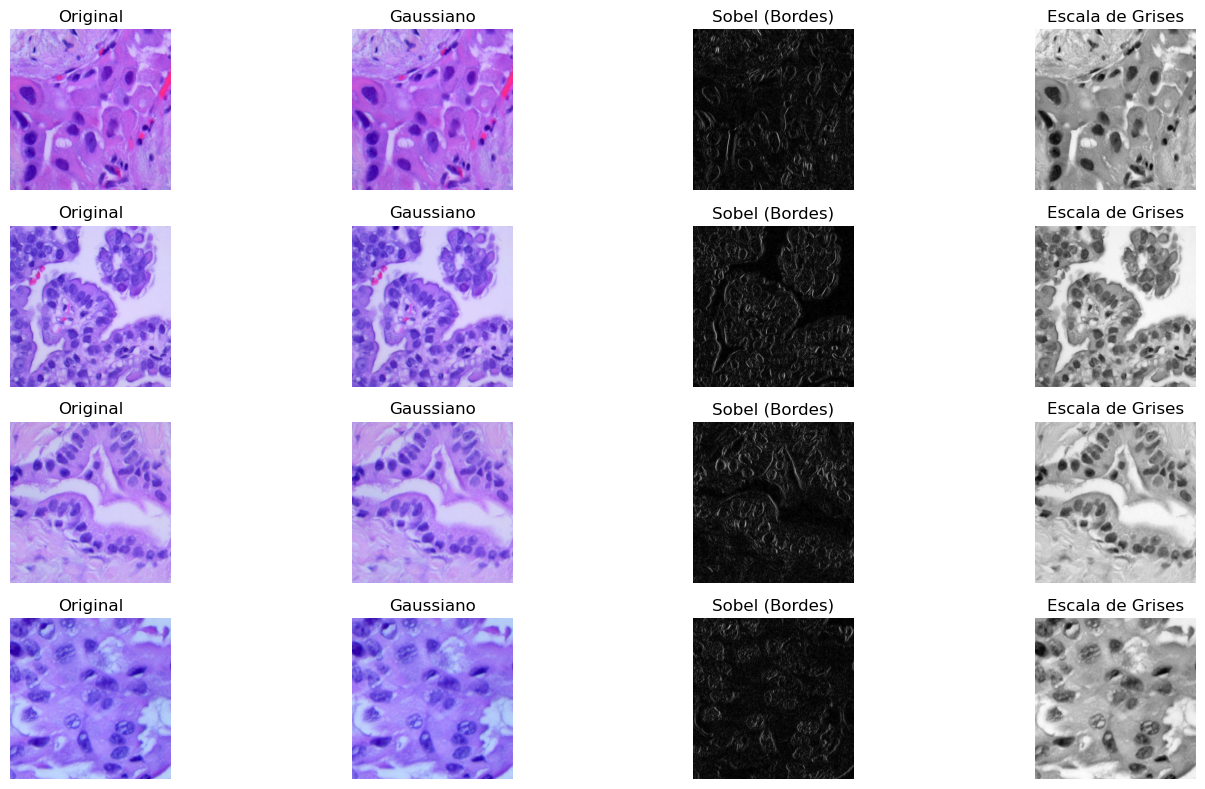


=== Tejido Benigno (lung_n) ===


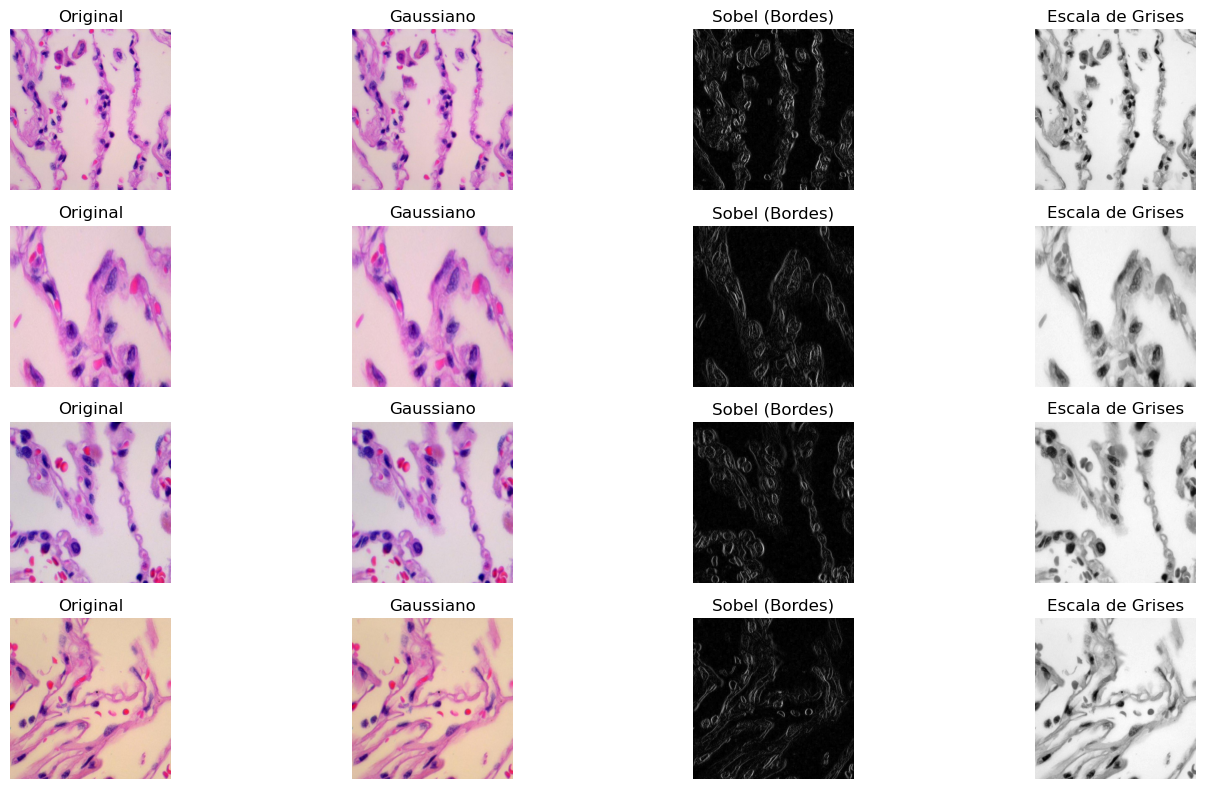


=== Carcinoma Escamoso (lung_scc) ===


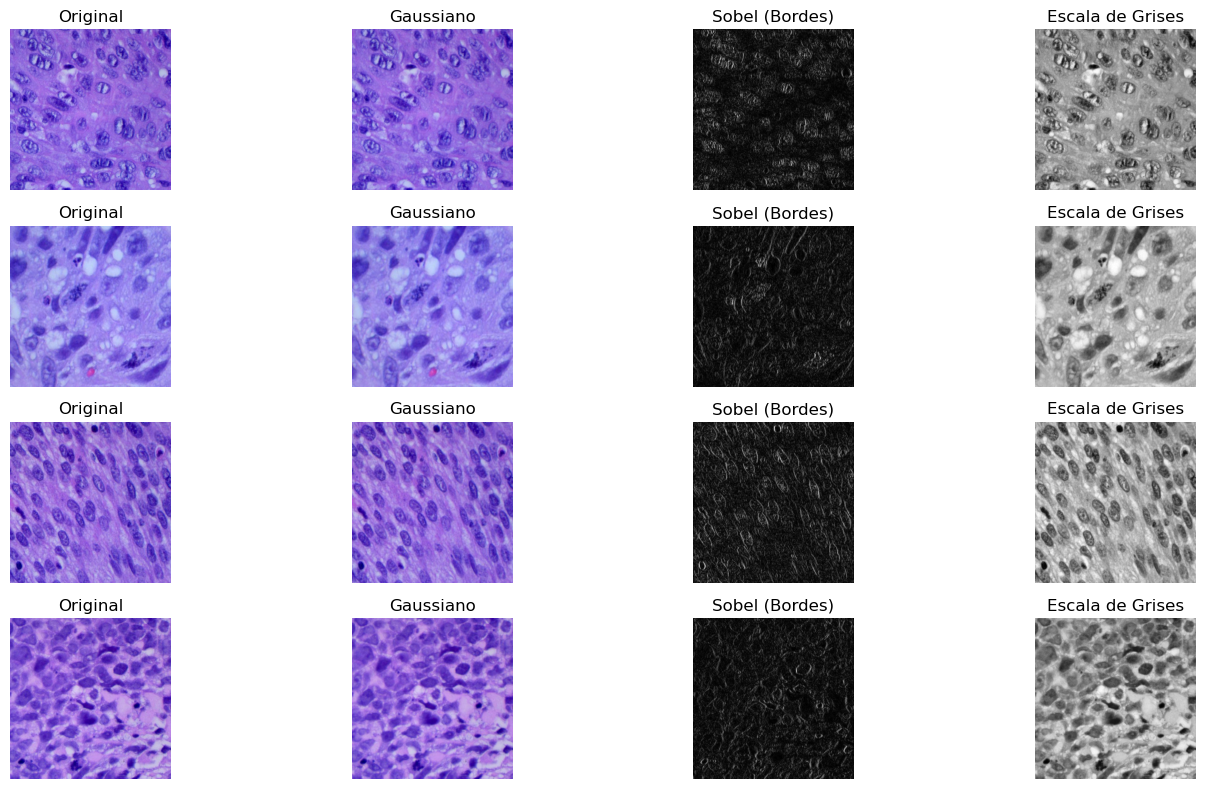

In [103]:
#Ejecutamos para cada clase
print("=== Adenocarcinoma (lung_aca) ===")
aplicando_filtro(lung_aca_path)

print("\n=== Tejido Benigno (lung_n) ===")
aplicando_filtro(lung_n_path)

print("\n=== Carcinoma Escamoso (lung_scc) ===")
aplicando_filtro(lung_scc_path)

In [153]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10)
])

dataset = datasets.ImageFolder(
    root='D:/CienciaDeDatos-Clases/lung_colon_image_set/lung_image_sets',
    transform=transform
)

In [111]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
datos_entrenamiento, datos_validacion = random_split(dataset, [train_size, val_size])

In [113]:
#dataLoaders
batch_size = 32
train_loader = DataLoader(datos_entrenamiento, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(datos_validacion, batch_size=batch_size, shuffle=False, num_workers=4)

In [119]:
#Modelo
model = models.efficientnet_b0(pretrained=True)

#Congelar parámetros
#Evita sobreescribir los patrones que ya aprendió
for param in model.parameters():
    param.requires_grad = False

#Capa clasificadora personalizada
model.classifier = nn.Sequential(
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3) #3 clases
)

model = model.to(device)

In [121]:
#ENTRENAMIENTO
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epocas = 10
for epoca in range(num_epocas):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    #Validación
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    print(f"Época {epoca+1}/{num_epocas}")
    print(f"Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")
    print(f"Val Accuracy: {100*correct/len(val_dataset):.2f}%\n")

Época 1/10
Train Loss: 0.2226 | Val Loss: 0.0955
Val Accuracy: 96.47%

Época 2/10
Train Loss: 0.1351 | Val Loss: 0.0782
Val Accuracy: 97.10%

Época 3/10
Train Loss: 0.1328 | Val Loss: 0.0545
Val Accuracy: 98.07%

Época 4/10
Train Loss: 0.1026 | Val Loss: 0.0472
Val Accuracy: 98.37%

Época 5/10
Train Loss: 0.0982 | Val Loss: 0.0401
Val Accuracy: 98.80%

Época 6/10
Train Loss: 0.0850 | Val Loss: 0.0387
Val Accuracy: 98.63%

Época 7/10
Train Loss: 0.0865 | Val Loss: 0.0343
Val Accuracy: 98.83%

Época 8/10
Train Loss: 0.0766 | Val Loss: 0.0300
Val Accuracy: 99.03%

Época 9/10
Train Loss: 0.0807 | Val Loss: 0.0318
Val Accuracy: 98.63%

Época 10/10
Train Loss: 0.0708 | Val Loss: 0.0221
Val Accuracy: 99.27%



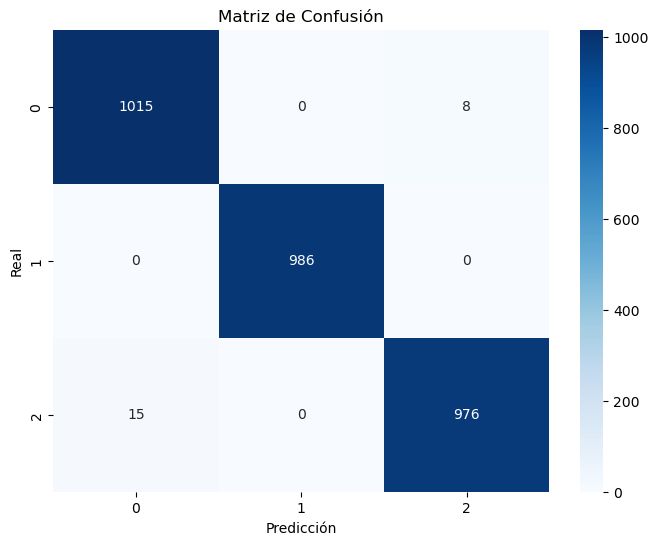

In [123]:
#Matriz de confusión
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [169]:
#PREDICCIÓN
def prediccion_de_imagen(image_path, model, device):
    """Predice la clase de una imagen"""
    img = Image.open(image_path).convert('RGB')
    img = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img)
        _, predicted = torch.max(output, 1)
        classes = ['lung_aca (adenocarcinoma)', 'lung_n (benigno)', 'lung_scc (carcinoma escamoso)']
        print(f"\nPredicción para {os.path.basename(image_path)}: {classes[predicted[0]]}")
    
    #Imagen con predicción
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicción: {classes[predicted[0]]}")
    plt.axis('off')
    plt.show()


Predicción para lungaca129.jpeg: lung_aca (adenocarcinoma)


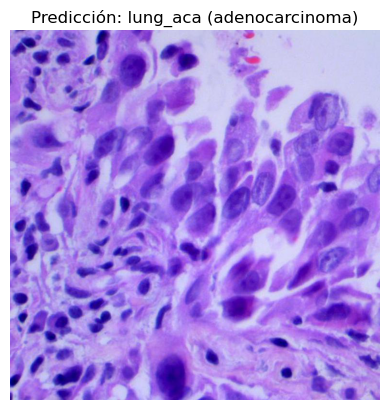

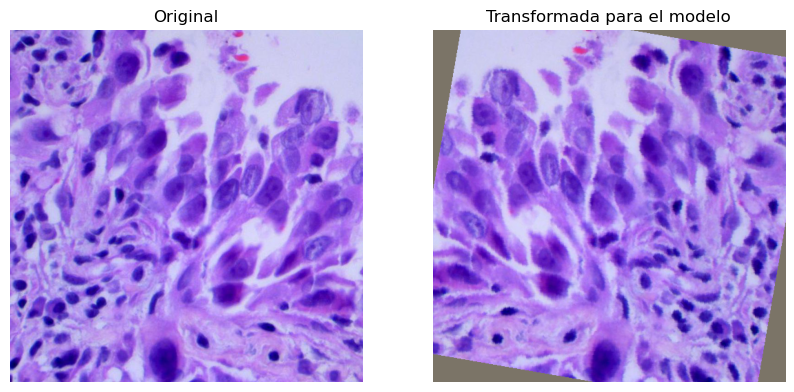

In [171]:
#Prueba con una imagen específica
image_path = r'D:\CienciaDeDatos-Clases\lung_colon_image_set\lung_image_sets\lung_aca\lungaca129.jpeg'
prediccion_de_imagen(image_path, model, device) #Predicción y muestra del resultado
mostrar_imagen(image_path, transform) #Comparación

# $\textcolor{purple}{\text{Conclusiones}}$

### Se obtuvo una precisión en validación del $99.27 \%.$

### La matriz de confusión muestra pocos errores entre clases,

### $8$ casos de adenocarcinoma clasificados como carcinoma y 

### $15$ casos de carcinoma clasificados como benigno. 

### El Filtro Sobel es optimo para resaltar bordes celulares.